<a href="https://colab.research.google.com/github/Ronin1289/Generating-Building-Drawings-Using-Image-Processing/blob/Experiments/EXPERIMENT_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DeepLSD

##Line Detection using Deep Learning

In [1]:
!git clone --recurse-submodules https://github.com/cvg/DeepLSD.git
%cd DeepLSD

Cloning into 'DeepLSD'...
remote: Enumerating objects: 266, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 266 (delta 29), reused 33 (delta 22), pack-reused 217 (from 1)
Receiving objects: 100% (266/266), 7.50 MiB | 11.08 MiB/s, done.
Resolving deltas: 100% (116/116), done.
Submodule 'line_refinement/pybind11' (https://github.com/pybind/pybind11) registered for path 'line_refinement/pybind11'
Submodule 'third_party/homography_est' (https://github.com/rpautrat/homography_est.git) registered for path 'third_party/homography_est'
Submodule 'third_party/progressive-x' (https://github.com/danini/progressive-x.git) registered for path 'third_party/progressive-x'
Submodule 'third_party/pytlbd' (https://github.com/iago-suarez/pytlbd.git) registered for path 'third_party/pytlbd'
Submodule 'third_party/pytlsd' (https://github.com/iago-suarez/pytlsd.git) registered for path 'third_party/pytlsd'
Cloning into '/content/DeepLSD/line

In [2]:
!bash quickstart_install.sh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 8.1 MB/s eta 0:00:00
Processing ./third_party/pytlsd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0

In [12]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

In [9]:
import torch
print(torch.__version__)

2.5.1+cu124


In [1]:
!pip install omegaconf

In [3]:
!pip install pytlsd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 9.9 MB/s eta 0:00:00


In [5]:
!pip install flow_vis

  Using cached flow_vis-0.1-py3-none-any.whl.metadata (731 bytes)
Using cached flow_vis-0.1-py3-none-any.whl (4.4 kB)


In [8]:
!pip install pytorch as torch

  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement as (from versions: none)
ERROR: No matching distribution found for as


In [6]:
from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [10]:

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': False,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 3,
        'grad_nfa': True,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}

# Load the model
ckpt = '/content/sample_data/deeplsd_md.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

<ipython-input-10-f8e75ac67dce>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(ckpt), map_location='cpu')


In [ ]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

In [18]:
import cv2
img=cv2.imread('/content/sample_data/gsck1.png',cv2.IMREAD_GRAYSCALE)

In [20]:
gray_img=img.copy()

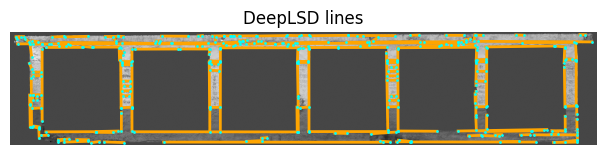

In [25]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))



In [31]:
print(type(pred_lines))
print(pred_lines.shape)
print(pred_lines[:5])

<class 'numpy.ndarray'>
(196, 2, 2)
[[[ 767.9727     39.14512 ]
  [ 860.02637    37.790527]]

 [[ 940.9994     51.639866]
  [ 682.99945    51.757072]]

 [[ 902.00037    38.05046 ]
  [1454.009      34.342663]]

 [[ 133.00264    38.388165]
  [ 746.998      39.00971 ]]

 [[1256.995     142.44476 ]
  [1226.005     142.54472 ]]]


In [33]:
!pip install ezdxf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 97.1 MB/s eta 0:00:00


In [35]:
import ezdxf

# Create a new DXF document
doc = ezdxf.new()
msp = doc.modelspace()

# Add lines to the DXF file
for line in pred_lines:
    (x1, y1), (x2, y2) = line
    msp.add_line((x1, y1), (x2, y2))

# Save the DXF file
doc.saveas("detected_lines.dxf")


In [36]:
from google.colab import files

# Specify the filename
filename = "detected_lines.dxf"

# Download the file
files.download(filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>